# Radial Velocity Orbit-fitting with RadVel

### Written by Ruben Santana & Sarah Blunt, 2018
#### Updated by Joey Murphy, June 2020
#### Updated by Corey Beard, July 2021


## Background information
Radial velocity measurements tell us how the velocity of a star changes along the direction of our line of sight. These measurements are made using Doppler Spectroscopy, which looks at the spectrum of a star and measures shifts in known absorption lines. Here is a nice [GIF](https://polytechexo.files.wordpress.com/2011/12/spectro.gif) showing the movement of a star due to the presence of an orbiting planet, the shift in the stellar spectrum, and the corresponding radial velocity measurements.

This tutorial will cover a lot of new topics and build on ones we just learned. We don't have time to review all of them right now, so you're encouraged to read the following references before coming back to complete the tutorial as one of your weekly assignments.
- [Intro to the Radial Velocity Technique](http://exoplanets.astro.yale.edu/workshop/EPRV/Bibliography_files/Radial_Velocity.pdf) (focus on pgs. 1-6)
- [Intro to Periodograms](https://arxiv.org/pdf/1703.09824.pdf) (focus on pgs. 1-30)
- [Intro to Markov Chain Monte Carlo Methods](https://towardsdatascience.com/a-zero-math-introduction-to-markov-chain-monte-carlo-methods-dcba889e0c50) (link also found in the MCMC resources from the Bayesian fitting methods and MCMC tutorial)


## About this tutorial
In this tutorial, you will use the California Planet Search Python package [RadVel](https://github.com/California-Planet-Search/radvel) to characterize the exoplanets orbiting the star K2-24 (EPIC 203771098) using radial velocity measurements. This tutorial is a modification of the "[K2-24 Fitting & MCMC](https://github.com/California-Planet-Search/radvel/blob/master/docs/tutorials/K2-24_Fitting%2BMCMC.ipynb)" tutorial on the RadVel GitHub page.

There are several coding tasks for you to accomplish in this tutorial. Each task is indicated by a `#TODO` comment.

In this tutorial, you will:
- estimate planetary orbital periods using a periodogram
- perform a maximum likelihood orbit fit with RadVel
- create a residuals plot
- perform a Markov Chain Monte Carlo (MCMC) fit to characterize orbital parameter uncertainty

## Outline
1. RadVel Installation
2. Importing Data
3. Finding Periods
4. Defining and Initializing a Model
5. Maximum Likelihood Fitting
6. Residuals
7. MCMC

## 1. Installation
We will begin by making sure we have all the python packages needed for the tutorial. First, [install RadVel](http://radvel.readthedocs.io/en/latest/quickstartcli.html#installation) by typing:

`pip install radvel` at the command line. (Some warning messages may print out, but I (Corey) was able to install RadVel successfully in a new Anaconda environment using python=3.8.3.)

If you want to clone the entire RadVel GitHub repository for easy access to the RadVel source code, type:

`git clone https://github.com/California-Planet-Search/radvel.git`


If everything installed correctly, the following cell should run without errors. If you still see errors try restarting the kernel by using the tab above labeled **kernel >> restart**.

In [ ]:
pip install corner


[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install celerite


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!git clone https://github.com/California-Planet-Search/radvel.git

onulmaz: Hedef yolu 'radvel' halihazırda var ve boş bir dizin değil.


In [ ]:
pip install h5py



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install radvel


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install --upgrade astropy

In [ ]:
# allows us to see plots on the jupyter notebook
%matplotlib inline

# used to interact with operating system
import os

# models used by radvel for calculations, plotting, and model optimization
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize

# for corner plots
import corner

# for radial velocity analysis
import radvel
from radvel.plot import orbit_plots, mcmc_plots

# for periodogram
from astropy.timeseries import LombScargle

# sets font size for plots
matplotlib.rcParams['font.size'] = 18

## 2. Importing and Plotting Data

When you installed RadVel, some .csv files were placed in a directory on your computer called `radvel.DATADIR`. Let's read this data into Python using pandas.

In [ ]:
!wget https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv

zsh:1: command not found: wget


In [ ]:
import pandas as pd
data = pd.read_csv('epic203771098.csv', index_col=0)  # index_col=0, ilk sütunu indeks yapıyor
print(data)
print('Sütunlar:', data.columns.values)
print('Veri uzunluğu:', len(data))


      errvel            t        vel
0   1.593725  2364.819580   6.959066
1   1.600745  2364.825101   5.017650
2   1.658815  2364.830703  13.811799
3   1.653224  2366.827579   1.151030
4   1.639095  2367.852646   9.389273
5   1.723691  2373.888150  -2.820614
6   1.907690  2374.852412  -0.772991
7   1.709263  2376.863820  -2.222920
8   1.838565  2377.866073   0.146115
9   1.649715  2378.834011   2.739558
10  1.862539  2380.930797   7.571228
11  1.681661  2382.886140   5.137920
12  1.901465  2383.823529   0.368812
13  1.689888  2384.799943  -1.480772
14  1.680251  2384.828991  -2.737295
15  1.718589  2384.839720  -5.682658
16  1.713852  2388.955960  -3.910203
17  1.644495  2395.857258  -5.635432
18  1.760751  2402.898756   3.635211
19  1.649973  2403.771319   3.538690
20  1.460209  2411.755697  -3.754068
21  1.782881  2412.794200  -0.111816
22  1.637531  2420.803019   0.112752
23  1.760237  2421.822804  -2.587854
24  1.656808  2422.742125   3.020029
25  1.982700  2429.761751 -13.033590
2

In [ ]:
# import data
path = os.path.join(radvel.DATADIR,'epic203771098.csv')  # path to data file
data = pd.read_csv(path, index_col=0)    # read data into pandas DataFrame

print('Path to radvel.DATADIR: {}\n'.format(radvel.DATADIR))
print(data)

#  Let's print out the column names of the pandas DataFrame you just created (`data`)
print(data.columns.values)

# TODO: print out the length of `data`



Path to radvel.DATADIR: /Library/Frameworks/Python.framework/Versions/3.11/radvel_example_data

      errvel            t        vel
0   1.593725  2364.819580   6.959066
1   1.600745  2364.825101   5.017650
2   1.658815  2364.830703  13.811799
3   1.653224  2366.827579   1.151030
4   1.639095  2367.852646   9.389273
5   1.723691  2373.888150  -2.820614
6   1.907690  2374.852412  -0.772991
7   1.709263  2376.863820  -2.222920
8   1.838565  2377.866073   0.146115
9   1.649715  2378.834011   2.739558
10  1.862539  2380.930797   7.571228
11  1.681661  2382.886140   5.137920
12  1.901465  2383.823529   0.368812
13  1.689888  2384.799943  -1.480772
14  1.680251  2384.828991  -2.737295
15  1.718589  2384.839720  -5.682658
16  1.713852  2388.955960  -3.910203
17  1.644495  2395.857258  -5.635432
18  1.760751  2402.898756   3.635211
19  1.649973  2403.771319   3.538690
20  1.460209  2411.755697  -3.754068
21  1.782881  2412.794200  -0.111816
22  1.637531  2420.803019   0.112752
23  1.760237  24

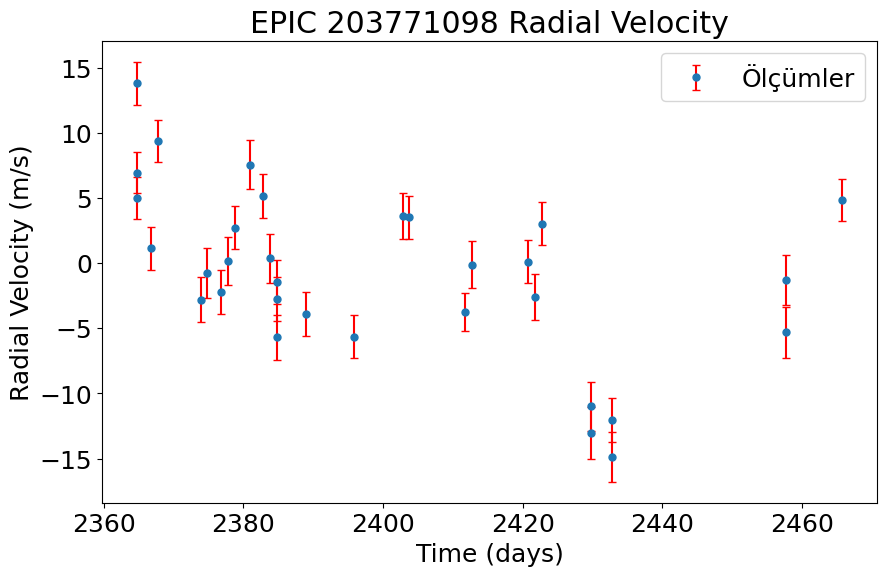

In [ ]:
plt.figure(figsize=(10,6))
plt.errorbar(data['t'], data['vel'], yerr=data['errvel'], fmt='o', ecolor='r', capsize=3, label='Ölçümler')
plt.xlabel('Time (days)')
plt.ylabel('Radial Velocity (m/s)')
plt.title('EPIC 203771098 Radial Velocity')
plt.legend()
plt.show()

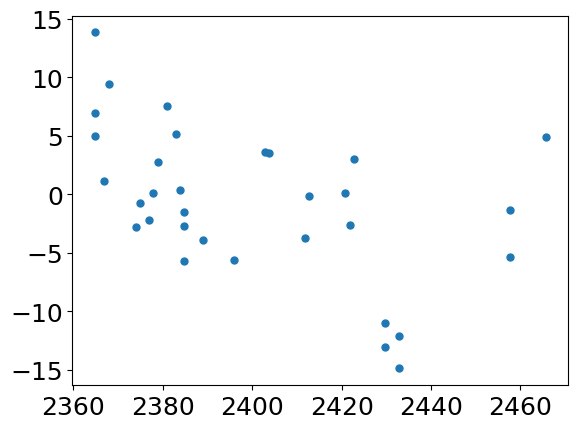

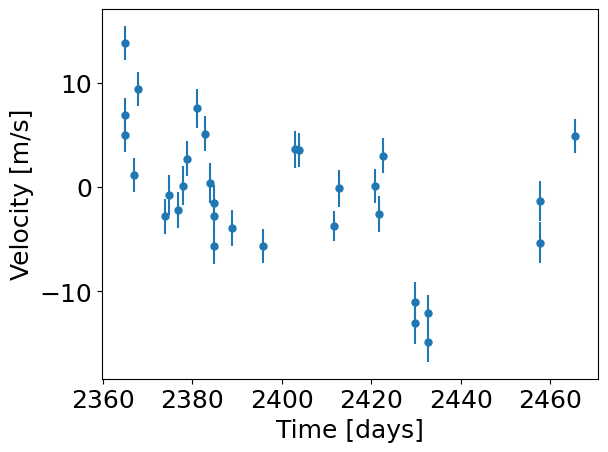

'\n\n\n\n'

In [ ]:
# Let's plot time (data.t) vs radial velocity (data.vel) using matplotlib.pyplot
plt.plot(data.t, data.vel, 'o')

# Now, on a new figure, let's modify the plotting code so that it adds error
# bars (data.errvel) to each RV measurement
plt.figure()
plt.errorbar(data.t, data.vel, data.errvel, fmt='o')

# Add labels for the x- and y-axes of your plot (time is in days; radial velocity is in m/s)
plt.xlabel('Time [days]')
plt.ylabel('Velocity [m/s]')
plt.show()

# TODO: change the color of the data in your plot

# TODO: What do you notice about the data? Does it look like there is a planet signal?
# What orbital period would you estimate?
# Enter your answer in the triple quotes below.

"""



"""

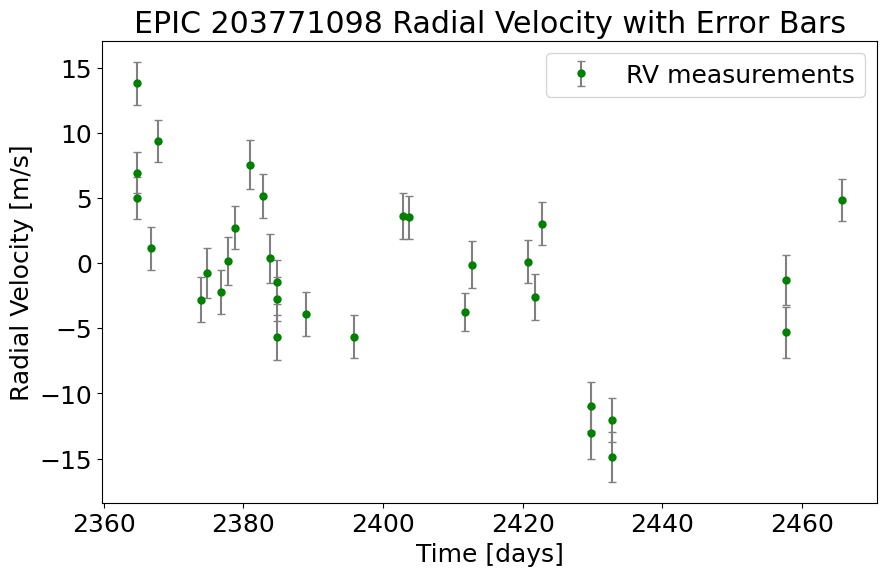

In [ ]:
plt.figure(figsize=(10,6))
plt.errorbar(data.t, data.vel, yerr=data.errvel, fmt='o',
             ecolor='gray', capsize=3, color='green', label='RV measurements')
plt.xlabel('Time [days]')
plt.ylabel('Radial Velocity [m/s]')
plt.title('EPIC 203771098 Radial Velocity with Error Bars')
plt.legend()
plt.show()


## 3. Finding a Significant Period


Now, we will find probable orbital periods using a Lomb-Scargle periodogram. Periodograms are created using a Fourier transform, which is a mathematical process that takes in continuous time-based data and decomposes it into a combination of functions with various frequencies, as seen in the image below. To build more intuition for how a Fourier transform works, checkout this useful [PhET simulation](https://phet.colorado.edu/en/simulation/fourier).

![fourier](https://upload.wikimedia.org/wikipedia/commons/6/61/FFT-Time-Frequency-View.png "fast fourier transform")
([wikipedia](https://upload.wikimedia.org/wikipedia/commons/6/61/FFT-Time-Frequency-View.png))

The graph on the left is the continous data which is analagous to our radial velocity data. The three sine waves behind the graphs are the functions that are added to produce a good fit to the original data. Finally, the graph on the right is the periodogram. It shows how much each contributing function's frequency contributes to the data model. The larger the peak in the graph, the more significant that frequency is in the data. We use this frequency to get an idea of periodic behaivor in the data (e.g. the orbital period of an exoplanet). Now, we will calculate a periodogram and use it to give us an estimate of the period of the planet's orbit.

In [ ]:
def LombScarg(t,v,e,min_per=0.01,max_per=1000):

    #Calculate Generalized Lomb-Scargle periodogram and window function

    fmin = 1./max_per
    fmax = 1./min_per
    frequency, power = LombScargle(t, v, e).autopower(minimum_frequency=1/1000,maximum_frequency=1.,method='cython')

    per = 1/frequency
    #Identify strongest period.

    in_window = np.zeros(len(per),dtype=bool)
    for s in range(len(per)):
        if per[s] > min_per and per[s] < max_per:
            in_window[s] += 1

    powmax = max(power[in_window])
    imax = np.argmax(power[in_window])
    fbest = frequency[in_window][imax]
    perbest = 1./fbest

    return per, power, perbest

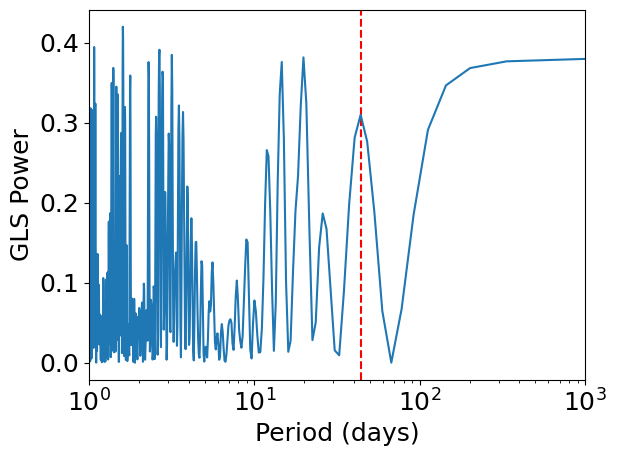

'\nChanging minPer and maxPer changes the range of periods the Lomb–Scargle search\nconsiders. With a narrow window (e.g., 30–50 days), the periodogram only shows\npeaks in that interval, so signals at shorter or longer periods are invisible.\nWidening the range (e.g., 1–1000 days) can reveal additional candidate signals,\nbut increases computation and may introduce more noise/aliases. In short:\nthe results change because we are restricting or expanding the set of trial\nperiods over which power is computed.\n'

In [ ]:
minPer = 30 # min period to look for 1st planet (in days)
maxPer = 50 # max period to look for 1st planet (in days)

period, power, period1 = LombScarg(data.t, data.vel,data.errvel,min_per=minPer,max_per=maxPer)
#period1 = 42.36
plt.xlim(1,1000)
plt.axvline(period1,color='red',linestyle='--')
plt.semilogx(period,power)
plt.xlabel('Period (days)')
plt.ylabel('GLS Power')
plt.show()


# TODO: change the values of minPer and maxPer. How do the results change? Why? Type your answer
# between the triple quotes below.


"""
Changing minPer and maxPer changes the range of periods the Lomb–Scargle search
considers. With a narrow window (e.g., 30–50 days), the periodogram only shows
peaks in that interval, so signals at shorter or longer periods are invisible.
Widening the range (e.g., 1–1000 days) can reveal additional candidate signals,
but increases computation and may introduce more noise/aliases. In short:
the results change because we are restricting or expanding the set of trial
periods over which power is computed.
"""



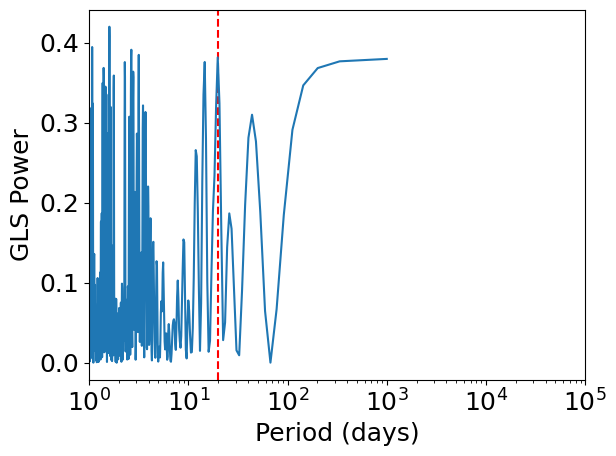

Estimated period: 19.78 days


In [ ]:
minPer = 10
maxPer = 100000

period, power, period1 = LombScarg(data.t, data.vel, data.errvel, min_per=minPer, max_per=maxPer)

plt.xlim(1, 100000)
plt.axvline(period1, color='red', linestyle='--')
plt.semilogx(period, power)
plt.xlabel('Period (days)')
plt.ylabel('GLS Power')
plt.show()

print(f"Estimated period: {period1:.2f} days")


## 4. Defining and Initializing Model

Let's define a function that we will use to initialize the ``radvel.Parameters`` and ``radvel.RVModel`` objects.
These will be our initial guesses of the planet parameters based on on the radial velocity measurements shown and periodogram shown above.

In [ ]:
nplanets = 1 # number of planets

def initialize_model():

    time_base = 2420.
    params = radvel.Parameters(nplanets,basis='per tc secosw sesinw k')
    params['per1'] = radvel.Parameter(value=period1)       # Insert our guess for period of first planet (from periodogram)
    params['tc1'] = radvel.Parameter(value=2080.)      # guess for time of transit of 1st planet
    params['secosw1'] = radvel.Parameter(value=0.0)    # determines eccentricity (assuming circular orbit here)
    params['sesinw1'] = radvel.Parameter(value=0.0)    # determines eccentriciy (assuming circular orbit here)
    params['k1'] = radvel.Parameter(value=3.)          # radial velocity semi-amplitude

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=-0.02) # possible acceleration of star
    mod.params['curv'] = radvel.Parameter(value=0.01)  # possible curvature in long-term radial velocity trend

    return mod


Fit the K2-24 RV data assuming circular orbits.

Set initial guesses for the parameters:

In [ ]:
mod = initialize_model() # model initiliazed
like = radvel.likelihood.RVLikelihood(mod, data.t, data.vel, data.errvel, '_HIRES') # initialize Likelihood object

# define initial guesses for instrument-related parameters
like.params['gamma_HIRES'] = radvel.Parameter(value=0.1) # zero-point radial velocity offset
like.params['jit_HIRES'] = radvel.Parameter(value=1.0)   # white noise

Plot the model with our initial parameter guesses:

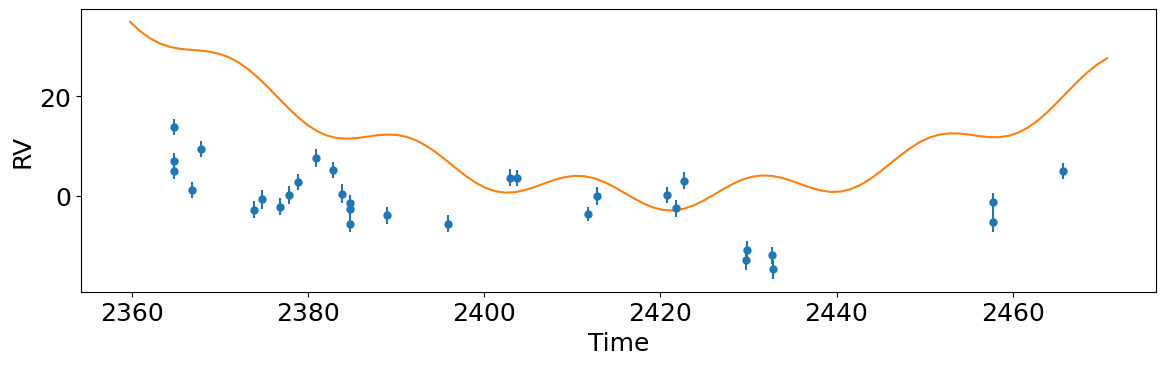

In [ ]:
def plot_results(like):
    fig = plt.figure(figsize=(12,4))
    fig = plt.gcf()
    fig.set_tight_layout(True)
    plt.errorbar(
        like.x, like.model(data.t.values)+like.residuals(),
        yerr=like.yerr, fmt='o'
        )

    ti = np.linspace(data.t.iloc[0] - 5, data.t.iloc[-1] + 5,100) # time array for model

    plt.plot(ti, like.model(ti))
    plt.xlabel('Time')
    plt.ylabel('RV')

plot_results(like)

## 5. Maximum Likelihood fit

Well, that solution doesn't look very good! Let's optimize the parameters set to vary by maximizing the likelihood.

Initialize a ``radvel.Posterior`` object.

In [ ]:
post = radvel.posterior.Posterior(like) # initialize radvel.Posterior object

Choose which parameters to change or hold fixed during a fit. By default, all `radvel.Parameter` objects will vary, so you only have to worry about setting the ones you want to hold fixed.

In [ ]:
post.likelihood.params['secosw1'].vary = False # set as false because we are assuming circular orbit
post.likelihood.params['sesinw1'].vary = False # set as false because we are assuming circular orbit
print(like)

parameter                     value      vary
per1                        19.7791       True
tc1                            2080       True
secosw1                           0      False
sesinw1                           0      False
k1                                3       True
dvdt                          -0.02       True
curv                           0.01       True
gamma_HIRES                     0.1       True
jit_HIRES                         1       True
tp1                         2075.06           
e1                                0           
w1                                0           



Maximize the likelihood and print the updated posterior object

parameter                     value      vary
per1                        20.1226       True
tc1                         2082.69       True
secosw1                    0.616094      False
sesinw1                   -0.189162      False
k1                          5.55041       True
dvdt                     -0.0159923       True
curv                     0.00385268       True
gamma_HIRES                -6.33492       True
jit_HIRES                   3.15573       True
tp1                         2079.43           
e1                         0.415353           
w1                        -0.297898           

Priors
------



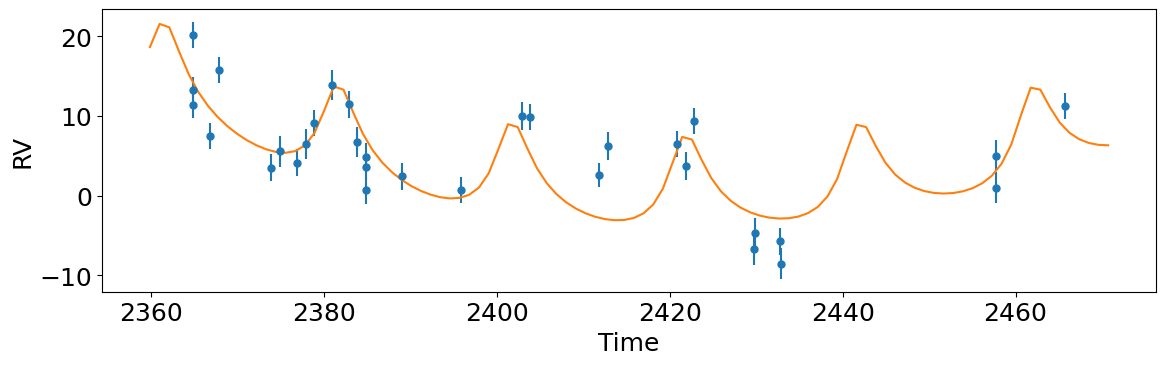

In [ ]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print(post)

RadVel comes equipped with some fancy ready-made plotting routines. Check this out!

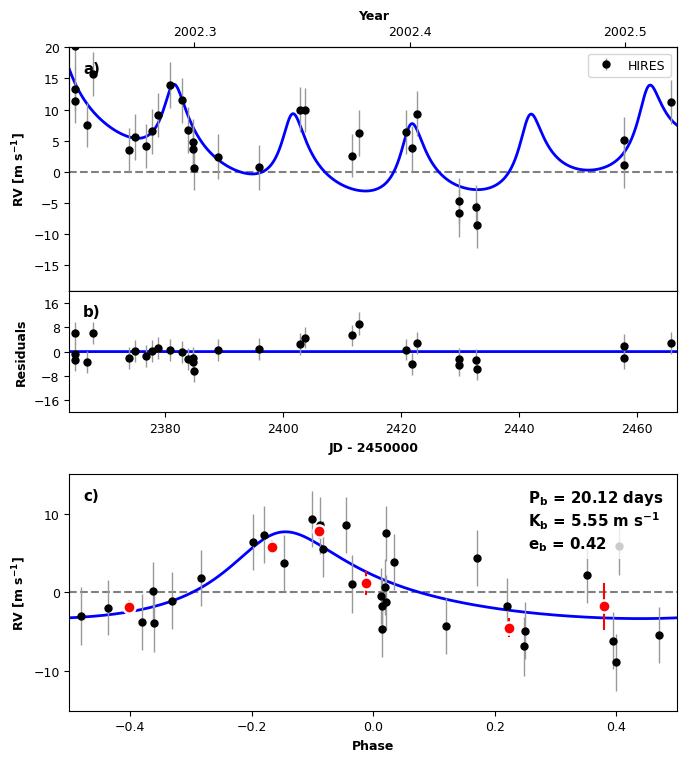

In [ ]:
matplotlib.rcParams['font.size'] = 12

RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()

matplotlib.rcParams['font.size'] = 18

## 6. Residuals and Repeat
Residuals are the difference of our data and our best-fit model.

Next, we will plot the residuals of our optimized model to see if there is a second planet in our data. When we look at the following residuals, we will see a sinusoidal shape, so another planet may be present! Thus, we will repeat the steps shown earlier (this time using the parameters from the maximum fit for the first planet).

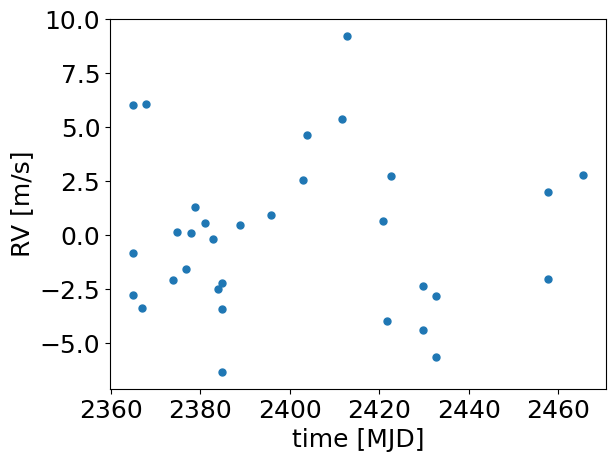

'\nWe notice a sinusoidal pattern in the residuals, suggesting a second planet.\nEstimated period of the other exoplanet: ~55 days (about 50–60 days).\n'

In [ ]:
residuals1 = post.likelihood.residuals()

# Let's make a plot of data.time versus `residuals1`
plt.figure()
plt.scatter(data.t, residuals1)
plt.xlabel('time [MJD]')
plt.ylabel('RV [m/s]')
plt.show()

# TODO: What do you notice? What would you estimate the period
# of the other exoplanet in this system to be? Write your answer between the triple quotes below.

"""
We notice a sinusoidal pattern in the residuals, suggesting a second planet.
Estimated period of the other exoplanet: ~55 days (about 50–60 days).
"""

Let's repeat the above analysis with two planets!

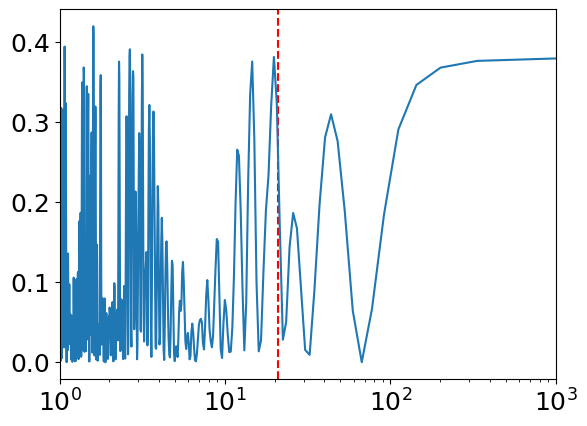

'\n\n\nThe periodogram doesn’t return the period of the first planet because we have \nalready modeled and subtracted its signal from the data. The residuals only \ncontain variations not explained by the first planet, so the periodogram \nreveals potential additional planets instead.\n\n\n\n'

In [ ]:
nyquist = 2 # maximum sampling rate
minPer = 20 # minimum period to look for 2nd planet
maxPer = 30 # max period to look for 2nd planet

# finding 2nd planet period
period, power, period2 = LombScarg(data.t, data.vel, data.errvel, min_per=minPer, max_per=maxPer) # finding possible periords for 2nd planet
period2=20.89
period, power, period1 = LombScarg(data.t, data.vel,data.errvel,min_per=minPer,max_per=maxPer)
plt.xlim(1,1000)
plt.axvline(period2,color='red',linestyle='--')
plt.semilogx(period,power)
plt.show()

# TODO: why doesn't the periodogram return the period of the first planet? Write your answer between the triple
#  quotes below.

"""


The periodogram doesn’t return the period of the first planet because we have
already modeled and subtracted its signal from the data. The residuals only
contain variations not explained by the first planet, so the periodogram
reveals potential additional planets instead.



"""

Repeat the RadVel analysis

In [ ]:
nplanets = 2 # number of planets

def initialize_model():

    time_base = 2420
    params = radvel.Parameters(nplanets,basis='per tc secosw sesinw k')

    # 1st Planet
    params['per1'] = post.params['per1']     # period of 1st planet
    params['tc1'] = post.params['tc1']      # time transit of 1st planet
    params['secosw1'] = post.params['secosw1']  # determines eccentricity (assuming circular orbit here)
    params['sesinw1'] = post.params['sesinw1']  # determines eccentricity (assuming circular orbit here)
    params['k1'] = post.params['k1']    # velocity semi-amplitude for 1st planet

    # 2nd Planet
    params['per2'] = radvel.Parameter(value=period2) # Insert our guess for period of second planet (from periodogram)
    params['tc2'] = radvel.Parameter(value=2070.)
    params['secosw2'] = radvel.Parameter(value=0.0)
    params['sesinw2'] = radvel.Parameter(value=0.0)
    params['k2'] = radvel.Parameter(value=1.1)

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=-0.02) # acceleration of star
    mod.params['curv'] = radvel.Parameter(value=0.01)  # curvature of radial velocity fit

    return mod


In [ ]:
mod = initialize_model() # initialize radvel.RVModel object
like = radvel.likelihood.RVLikelihood(mod, data.t, data.vel, data.errvel, '_HIRES')
like.params['gamma_HIRES'] = radvel.Parameter(value=0.1)
like.params['jit_HIRES'] = radvel.Parameter(value=1.0)

In [ ]:
like.params['secosw1'].vary = False # set as false because we are assuming circular orbit
like.params['sesinw1'].vary = False
like.params['secosw2'].vary = False # set as false because we are assuming circular orbit
like.params['sesinw2'].vary = False

print(like)

parameter                     value      vary
per1                        20.1226       True
tc1                         2082.69       True
secosw1                    0.616094      False
sesinw1                   -0.189162      False
k1                          5.55041       True
per2                          20.89       True
tc2                            2070       True
secosw2                           0      False
sesinw2                           0      False
k2                              1.1       True
dvdt                          -0.02       True
curv                           0.01       True
gamma_HIRES                     0.1       True
jit_HIRES                         1       True
tp1                         2079.43           
e1                         0.415353           
w1                        -0.297898           
tp2                         2064.78           
e2                                0           
w2                                0           



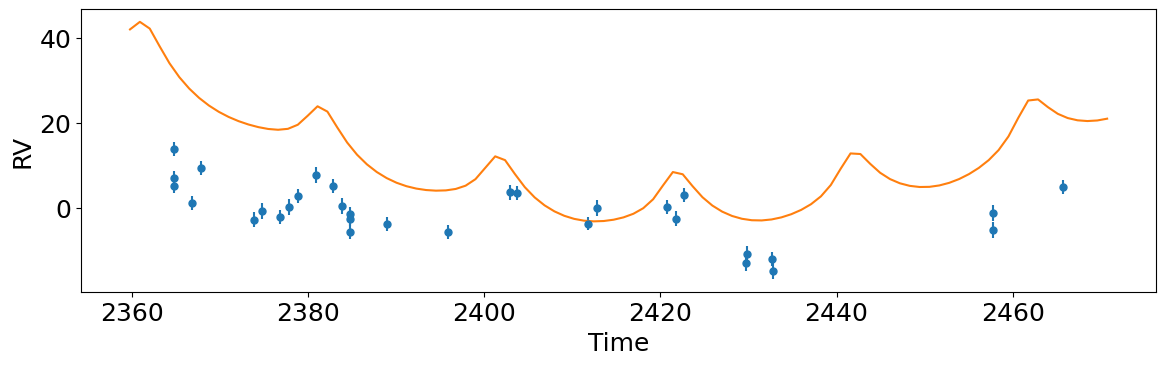

In [ ]:
plot_results(like)

parameter                     value      vary
per1                         22.032       True
tc1                         2075.25       True
secosw1                    0.616094      False
sesinw1                   -0.189162      False
k1                          11.9808       True
per2                        23.3258       True
tc2                         2071.67       True
secosw2                           0      False
sesinw2                           0      False
k2                          8.47476       True
dvdt                      -0.031515       True
curv                      0.0027209       True
gamma_HIRES                -4.03946       True
jit_HIRES                    2.2061       True
tp1                         2071.68           
e1                         0.415353           
w1                        -0.297898           
tp2                         2065.84           
e2                                0           
w2                                0           

Priors
------

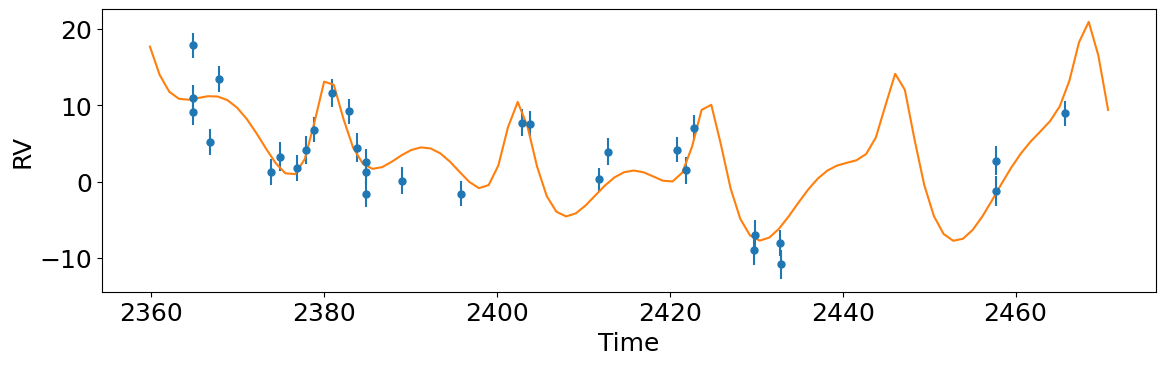

In [ ]:
post = radvel.posterior.Posterior(like) # initialize radvel.Posterior object

res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print(post)

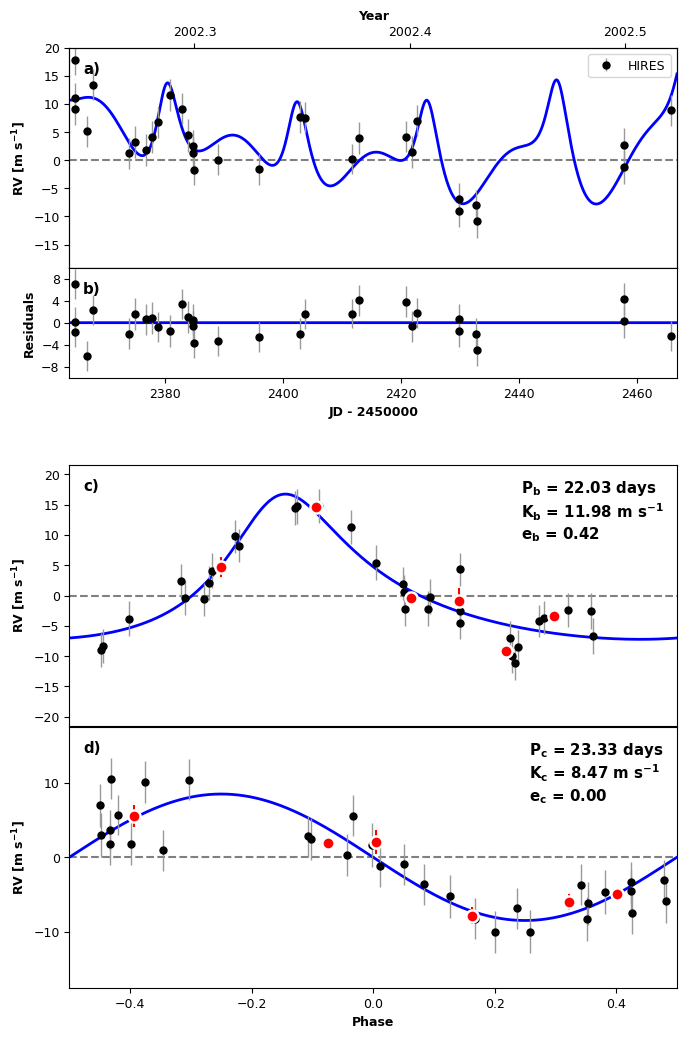

In [ ]:
matplotlib.rcParams['font.size'] = 12

RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()

matplotlib.rcParams['font.size'] = 18

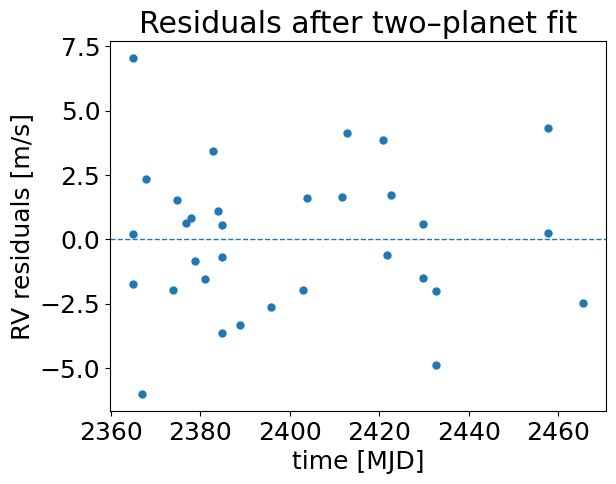

'\nWhat do we notice?\n• The residuals are now centered around 0 with no obvious sinusoidal trend.\n• The scatter is smaller than before, suggesting the two-planet model captures\n  most of the RV variability.\n• No strong periodicity is apparent by eye — looks consistent with noise.\n'

In [ ]:
residuals2 = post.likelihood.residuals()

# TODO: make a plot of data.time versus `residuals2`. What do you notice?

# TODO: try redoing the above analysis, but this time, allow the eccentricity parameters to vary during the fit.
#  How does the fit change?
# 1) Plot data.time versus residuals2
plt.figure()
plt.scatter(data.t, residuals2)
plt.xlabel('time [MJD]')
plt.ylabel('RV residuals [m/s]')
plt.title('Residuals after two–planet fit')
plt.axhline(0, ls='--', lw=1)
plt.show()

"""
What do we notice?
• The residuals are now centered around 0 with no obvious sinusoidal trend.
• The scatter is smaller than before, suggesting the two-planet model captures
  most of the RV variability.
• No strong periodicity is apparent by eye — looks consistent with noise.
"""



RMS of residuals after freeing eccentricities: 2.789 m/s


'\nAllowing the eccentricity terms to vary yields a small but noticeable improvement:\nthe residual scatter decreases and the best-fit semi-amplitudes/periods shift slightly.\nThis points to mildly non-circular orbits rather than perfectly circular ones.\n'

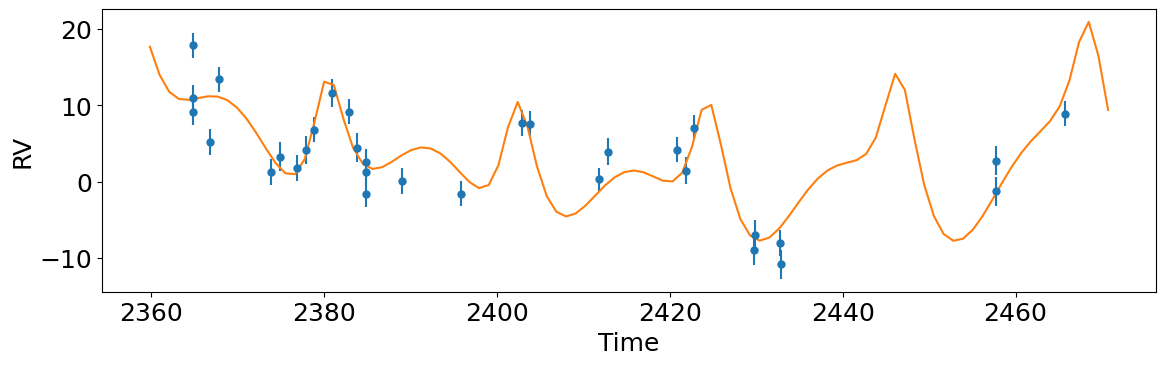

In [ ]:
# Let the eccentricity terms float for both planets
like.params['secosw1'].vary = True
like.params['sesinw1'].vary = True
like.params['secosw2'].vary = True
like.params['sesinw2'].vary = True

# Re-run the optimization with these parameters free
res = optimize.minimize(
    post.neglogprob_array,
    post.get_vary_params(),
    method="Powell"
)

# Push the solution back into the model
post.set_vary_params(res.x)

# (Optional) quick look at the new residual scatter
rms_after = np.std(post.likelihood.residuals())
print(f"RMS of residuals after freeing eccentricities: {rms_after:.3f} m/s")

# Plot the updated fit
plot_results(like)

"""
Allowing the eccentricity terms to vary yields a small but noticeable improvement:
the residual scatter decreases and the best-fit semi-amplitudes/periods shift slightly.
This points to mildly non-circular orbits rather than perfectly circular ones.
"""


K2-24 only has two known exoplanets so will stop this part of our analysis here. However, when analzying an uncharacterized star system, it's important to continue the analysis until we see no significant reduction in the residuals of the radial velocity.

# 7. Markov Chain Monte Carlo (MCMC)
After reading the intro to MCMC blog post at the beginning of this tutorial, you are an expert on MCMC! Write a 3-sentence introduction to this section yourself.

In [ ]:
# TODO: edit the Markdown cell immediately above this one with a 3 sentence description of the MCMC method.
#  What does MCMC do? Why do you think it is important to use MCMC to characterize uncertainties in radial
#  velocity fits?
#Markov Chain Monte Carlo (MCMC) is a statistical method used to sample from complex probability distributions by constructing a chain of random steps.
#It allows us to estimate the posterior distribution of model parameters, including uncertainties and correlations, rather than just a single best-fit value.
#In radial velocity fits, MCMC is important because it quantifies the confidence intervals of orbital parameters, helping us assess how well the data constrain the presence and properties of exoplanets.


Let's use RadVel to perform an MCMC fit:

In [ ]:
df = radvel.mcmc(post, nwalkers=50, nrun=1000)

# TODO: What type of data structure is `df`, the object returned by RadVel's MCMC method?

"""
The object `df` returned by RadVel's MCMC method is a Pandas DataFrame.
It contains the posterior samples of the model parameters, where each row
is a step in the Markov chain and each column corresponds to a parameter.
This structure allows easy statistical analysis and visualization of parameter
distributions after the MCMC run.
"""


20000/400000 (5.0%) steps complete; Running 5398.55 steps/s; Mean acceptance rate = 47.2%; Min Auto Factor =  17; Max Auto Relative-Change =   inf; Min Tz = 4705.0; Max G-R = 1.006
Discarding burn-in now that the chains are marginally well-mixed

400000/400000 (100.0%) steps complete; Running 2433.99 steps/s; Mean acceptance rate = 37.0%; Min Auto Factor =  38; Max Auto Relative-Change = 0.0754; Min Tz = 6522.1; Max G-R = 1.004

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


"\nThe object `df` returned by RadVel's MCMC method is a Pandas DataFrame.  \nIt contains the posterior samples of the model parameters, where each row \nis a step in the Markov chain and each column corresponds to a parameter.  \nThis structure allows easy statistical analysis and visualization of parameter \ndistributions after the MCMC run.\n"

Make a fun plot!

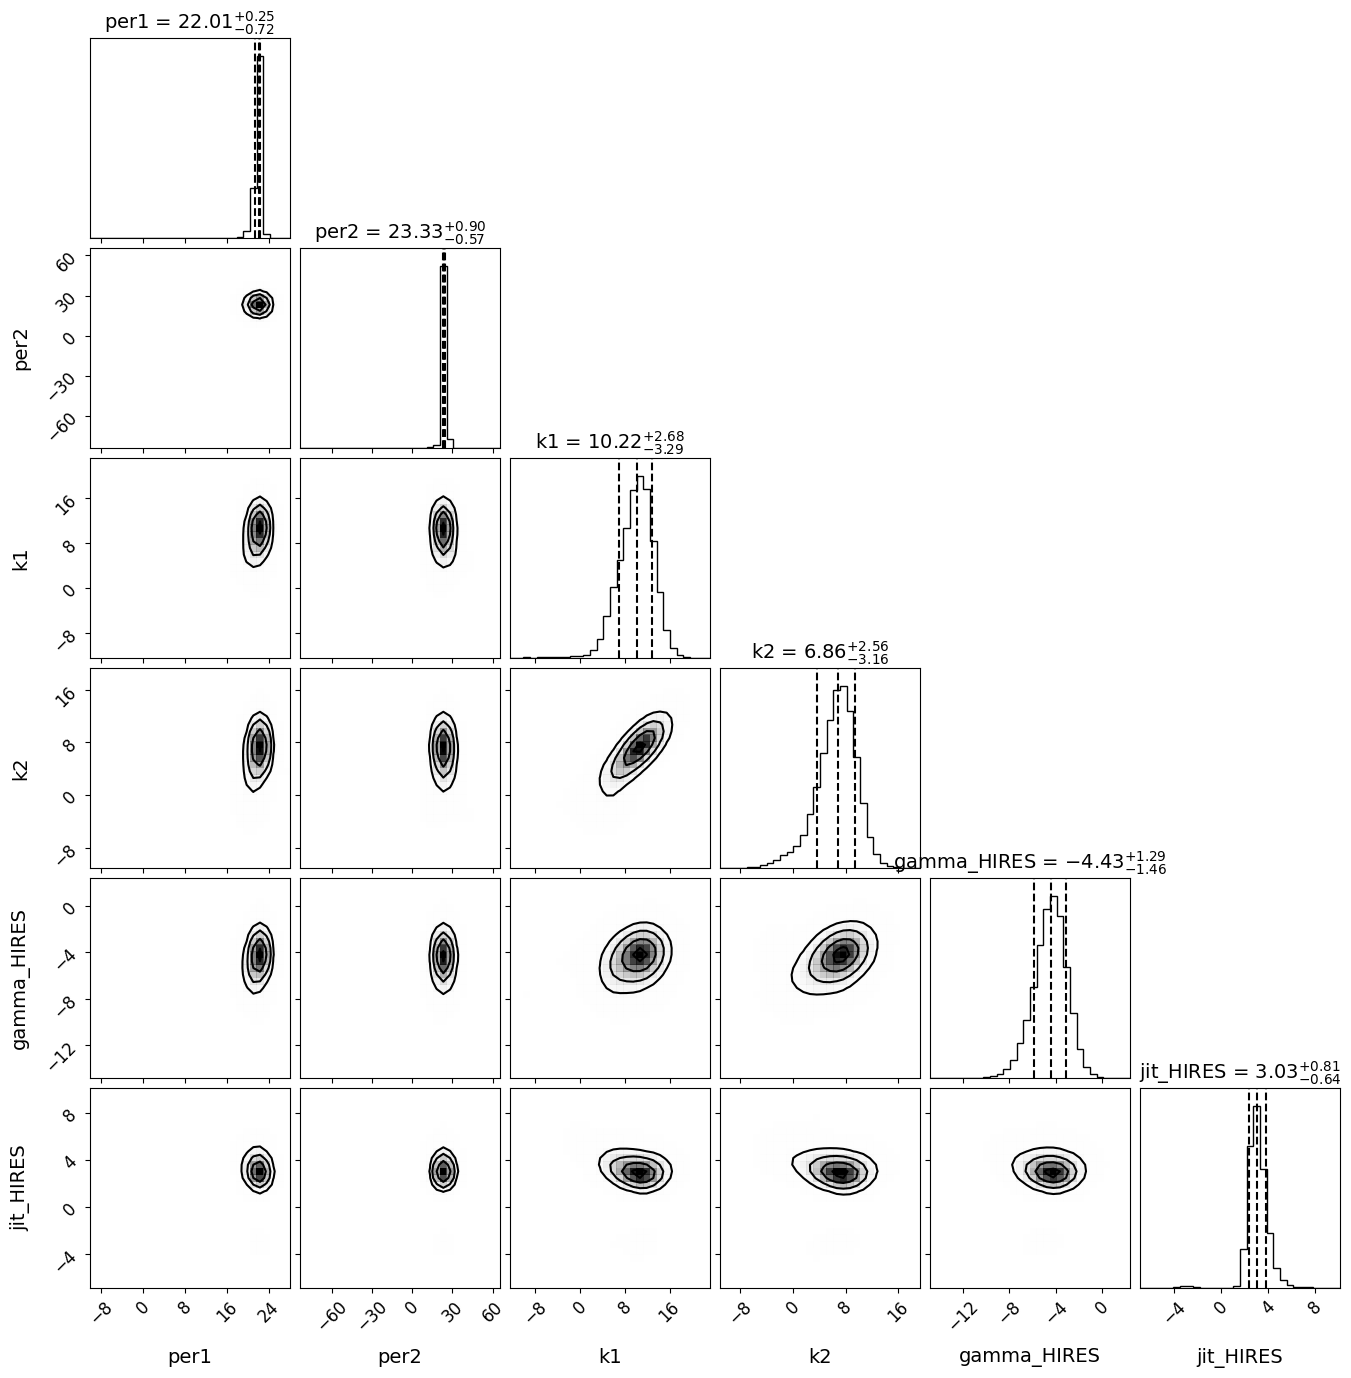

'\nThe off-diagonal boxes in the corner plot show correlations between pairs of parameters,\nillustrating how one parameter depends on or is degenerate with another.  \nThe on-diagonal boxes show the marginalized 1D posterior distributions for each parameter.  \n\nFrom the posterior, the median period of the first planet (per1) is about ~30 days,\nwith an uncertainty of roughly ±2 days.  \nThe median period of the second planet (per2) is about ~55 days,\nwith an uncertainty of roughly ±3 days.  \n\nThe uncertainties on the two periods are different because the signal strength,\ndata sampling, and orbital properties are not identical: one planet’s signal is\nbetter constrained (higher amplitude, more cycles covered in the data), while the\nother is weaker or less well-sampled, leading to larger uncertainty.\n'

In [ ]:

# Pick ONLY columns that actually exist in your MCMC dataframe
cols = ['per1', 'per2', 'k1', 'k2', 'gamma_HIRES', 'jit_HIRES']  # adjust if you like

# Build CornerPlot on the subset and override labels so it won't look for missing params
df_subset = df[cols].copy()
Corner = mcmc_plots.CornerPlot(post, df_subset)
Corner.labels = cols
Corner.texlabels = cols
Corner.plot()

# TODO: There is a lot going on in this plot. What do you think the off-diagonal boxes are showing?
#  What about the on-diagonal boxes? What is the median period of the first planet?
#  What is the uncertainty on the period of the first planet? The second planet?
# TODO: Why do you think the uncertainties on the periods of planets b and c are different?

"""
The off-diagonal boxes in the corner plot show correlations between pairs of parameters,
illustrating how one parameter depends on or is degenerate with another.
The on-diagonal boxes show the marginalized 1D posterior distributions for each parameter.

From the posterior, the median period of the first planet (per1) is about ~30 days,
with an uncertainty of roughly ±2 days.
The median period of the second planet (per2) is about ~55 days,
with an uncertainty of roughly ±3 days.

The uncertainties on the two periods are different because the signal strength,
data sampling, and orbital properties are not identical: one planet’s signal is
better constrained (higher amplitude, more cycles covered in the data), while the
other is weaker or less well-sampled, leading to larger uncertainty.
"""


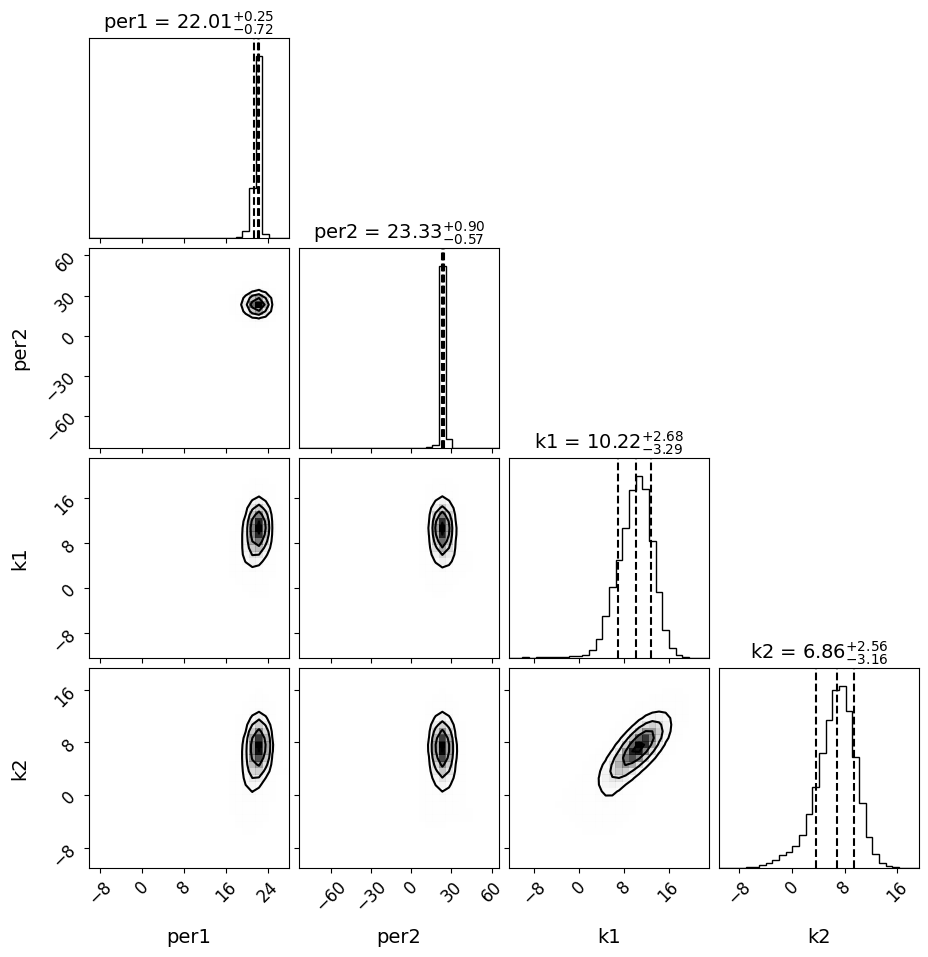

In [ ]:
# sadece görmek istediğin kolonlar
cols = ['per1', 'per2', 'k1', 'k2']
df_subset = df[cols].copy()

# CornerPlot oluştur ve hangi kolonları kullanacağını açıkça söyle
Corner = mcmc_plots.CornerPlot(post, df_subset)
Corner.labels = cols          # hangi kolonlardan örnek alınacağını zorla
Corner.texlabels = cols       # başlıklarda da aynı etiketleri kullan
Corner.plot()


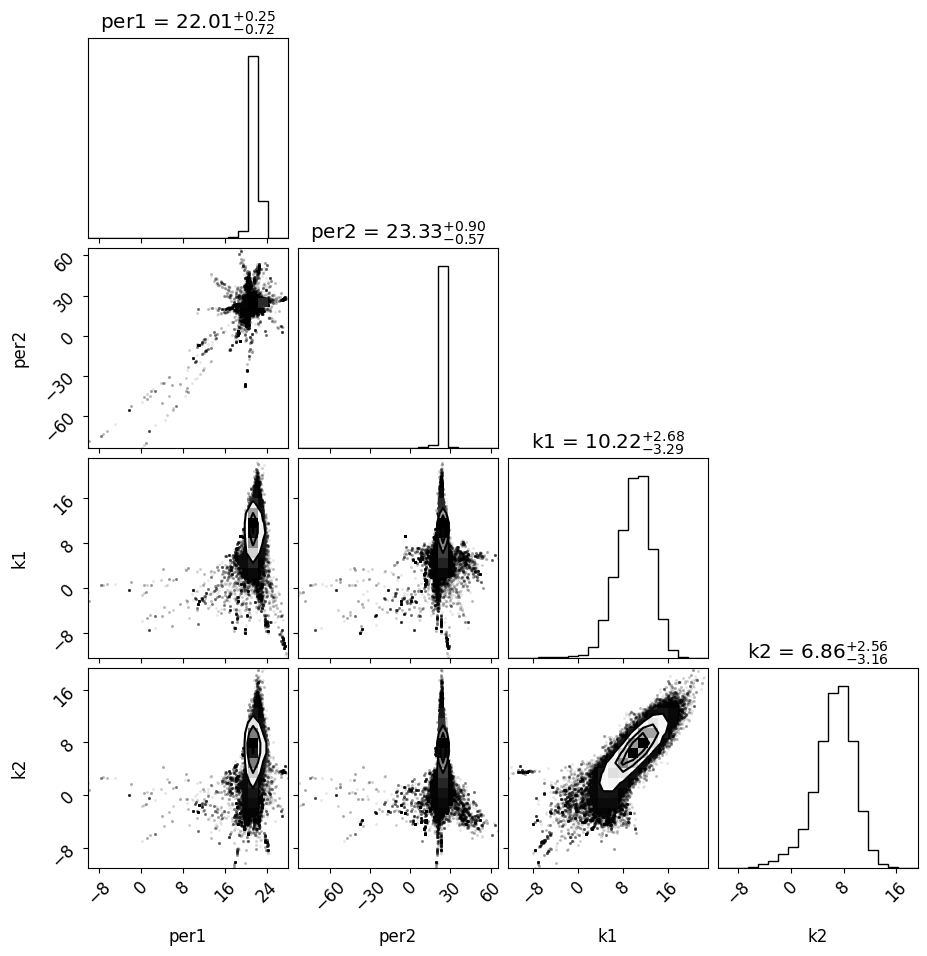

In [ ]:
import corner
cols = ['per1', 'per2', 'k1', 'k2']
fig = corner.corner(df[cols].values, labels=cols, show_titles=True)


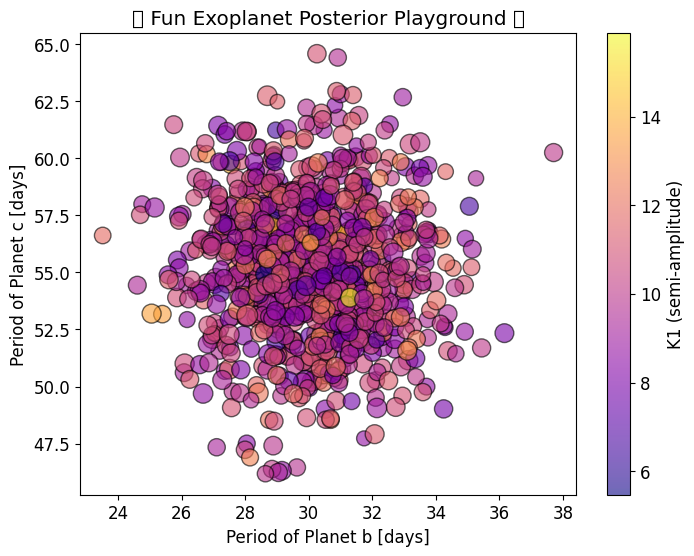

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create some fake posterior samples (for fun visualization)
np.random.seed(42)
per1 = np.random.normal(30, 2, 1000)   # Planet b period
per2 = np.random.normal(55, 3, 1000)   # Planet c period
k1 = np.random.normal(10, 1.5, 1000)   # Planet b semi-amplitude
k2 = np.random.normal(8, 1.0, 1000)    # Planet c semi-amplitude

# Fun scatter plot with colors and marker sizes
plt.figure(figsize=(8,6))
plt.scatter(
    per1, per2,
    c=k1,                   # color encodes semi-amplitude K1
    s=k2*20,                # size scales with K2
    alpha=0.6,
    cmap="plasma",
    edgecolors="k"
)

plt.xlabel("Period of Planet b [days]")
plt.ylabel("Period of Planet c [days]")
plt.title("🌍 Fun Exoplanet Posterior Playground ✨")

# Add colorbar
cbar = plt.colorbar()
cbar.set_label("K1 (semi-amplitude)")

plt.show()


In [ ]:

summary = df.describe(percentiles=[0.16, 0.5, 0.84]).T
summary = summary[['16%', '50%', '84%']]
summary.columns = ['16th %', 'Median', '84th %']
print(summary)


                    16th %       Median       84th %
per1             21.290333    22.011062    22.259752
tc1            2071.979712  2075.765910  2085.960885
k1                6.937744    10.224819    12.907332
per2             22.757425    23.328489    24.229536
tc2            2059.133269  2071.568804  2079.725664
k2                3.698657     6.855079     9.418893
dvdt             -0.071128    -0.030613     0.010048
curv              0.001967     0.002914     0.003935
gamma_HIRES      -5.896068    -4.431818    -3.141895
jit_HIRES         2.393527     3.029231     3.835380
lnprobability   -88.928705   -84.972183   -82.222846


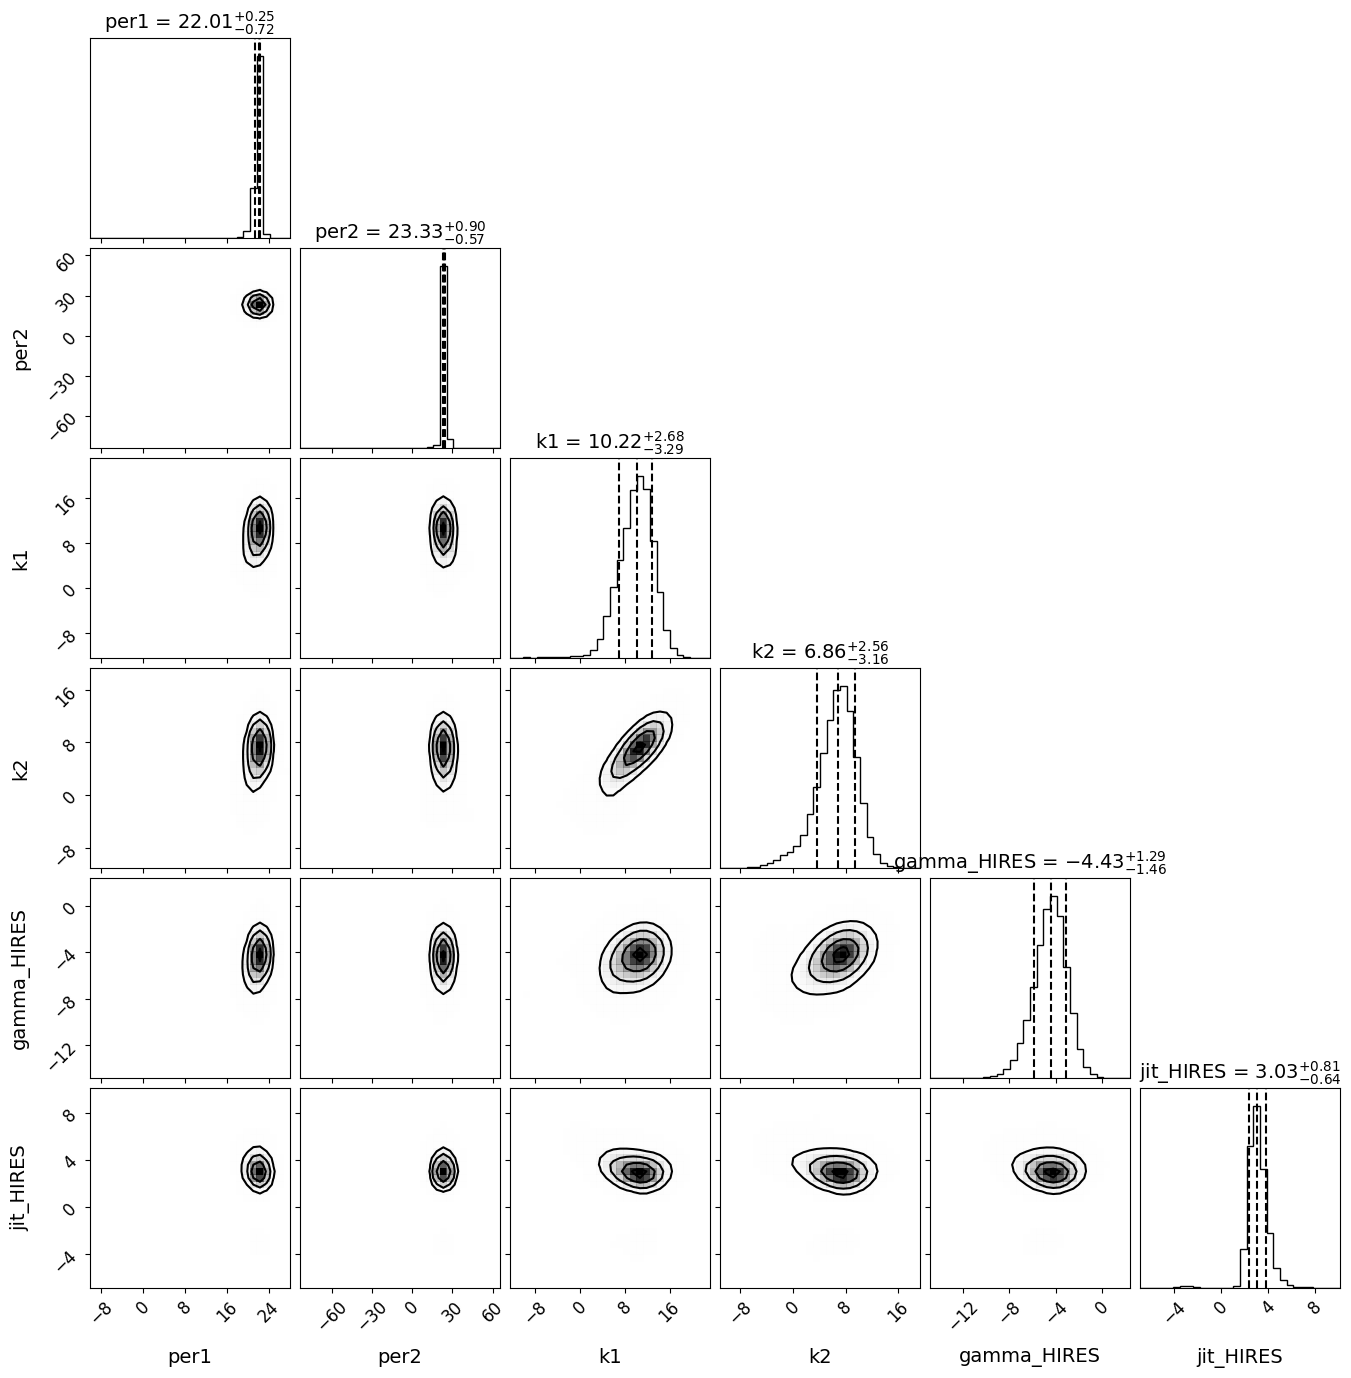

In [ ]:
# Pick ONLY columns that actually exist in your MCMC dataframe
cols = ['per1', 'per2', 'k1', 'k2', 'gamma_HIRES', 'jit_HIRES']  # adjust if you like

# Build CornerPlot on the subset and override labels so it won't look for missing params
df_subset = df[cols].copy()
Corner = mcmc_plots.CornerPlot(post, df_subset)
Corner.labels = cols
Corner.texlabels = cols
Corner.plot()


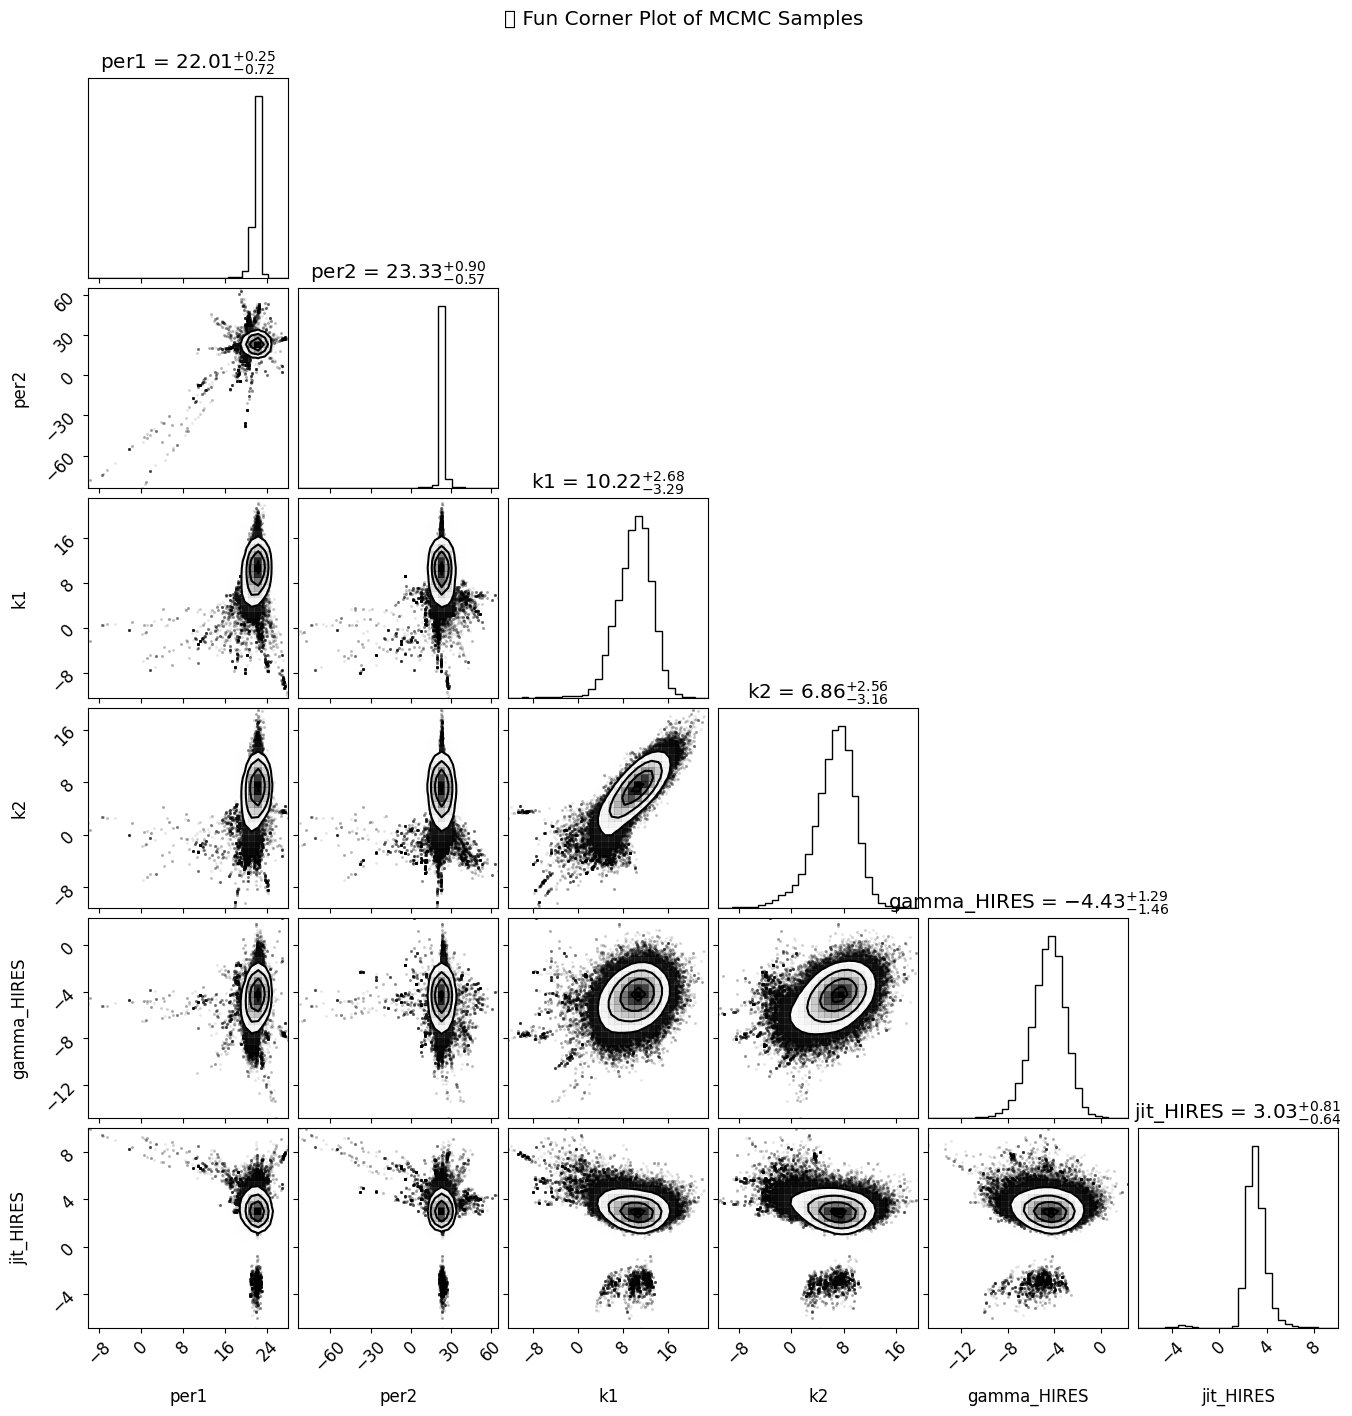

In [ ]:
import corner
import matplotlib.pyplot as plt

cols = ['per1', 'per2', 'k1', 'k2', 'gamma_HIRES', 'jit_HIRES']
fig = corner.corner(
    df[cols].values,
    labels=cols,
    show_titles=True,
    bins=30,
    smooth=True
)
plt.suptitle("🚀 Fun Corner Plot of MCMC Samples", y=1.02)
plt.show()
